In [1]:
from pathlib import Path

import cv2 as cv
import exposure_fusion as ef
import matplotlib.pyplot as plt
import numpy as np

from dhdrnet.util import DATA_DIR, ROOT_DIR

figdir = ROOT_DIR / "figures"

%load_ext autoreload
%autoreload 2
%matplotlib inline

4KK2_20150910_151036_908.png

0037_20160716_115039_415.png

0094_20150412_110436_460.png


In [2]:
from random import sample

image_names = [
    "4KK2_20150910_151036_908",
    "0037_20160716_115039_415",
    "0094_20150412_110436_460",
    "33TJ_20150810_173750_121",
    "0009_20160710_122940_904",
    "33TJ_20150731_191218_412",
]

# image_names = [
#     p.stem
#     for p in sample(
#         list((DATA_DIR / "correct_exposures" / "ground_truth").iterdir()), k=5
#     )
# ]
exposure_files = [
    (DATA_DIR / "correct_exposures" / "exposures").glob(f"{name}*")
    for name in image_names
]

ev_list = [-4.0, -1.0, 0.0, 1.0, 4.0]
exposure_files = [
    [file for file in files if any(f"[{ev}]" in file.name for ev in ev_list)]
    for files in exposure_files
]
exposure_files

[[PosixPath('/home/shane/src/DHDRNet/data/correct_exposures/exposures/4KK2_20150910_151036_908[0.0].png'),
  PosixPath('/home/shane/src/DHDRNet/data/correct_exposures/exposures/4KK2_20150910_151036_908[1.0].png'),
  PosixPath('/home/shane/src/DHDRNet/data/correct_exposures/exposures/4KK2_20150910_151036_908[4.0].png'),
  PosixPath('/home/shane/src/DHDRNet/data/correct_exposures/exposures/4KK2_20150910_151036_908[-1.0].png'),
  PosixPath('/home/shane/src/DHDRNet/data/correct_exposures/exposures/4KK2_20150910_151036_908[-4.0].png')],
 [PosixPath('/home/shane/src/DHDRNet/data/correct_exposures/exposures/0037_20160716_115039_415[0.0].png'),
  PosixPath('/home/shane/src/DHDRNet/data/correct_exposures/exposures/0037_20160716_115039_415[1.0].png'),
  PosixPath('/home/shane/src/DHDRNet/data/correct_exposures/exposures/0037_20160716_115039_415[4.0].png'),
  PosixPath('/home/shane/src/DHDRNet/data/correct_exposures/exposures/0037_20160716_115039_415[-1.0].png'),
  PosixPath('/home/shane/src/DHDR

In [3]:
from dhdrnet.gen_pairs import GenAllPairs

generator = GenAllPairs(
    raw_path=DATA_DIR / "dngs",
    out_path=DATA_DIR / "correct_exposures",
    store_path=None,
    compute_scores=False,
)

In [4]:
loaded_image_groups = [
    [cv.imread(str(im_path)) for im_path in exp_group] for exp_group in exposure_files
]
# fused_images = [
#     ef.exposure_fusion(aligned_images, depth=4)
#     for aligned_images in aligned_image_groups
# ]
weight_maps_per_image = [
    ef.compute_weights(images, None) for images in loaded_image_groups
]
fused_images = [generator.get_fused(name, ev_list=ev_list) for name in image_names]

In [5]:
weight_maps_per_image[0][0].max()
# plt.tight_layout()
# # plt.xticks(ticks=[])
# for weight_maps, fused, name in zip(weight_maps_per_image, fused_images, image_names):
#     fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(13, 7))
#     fig.suptitle(f"Weight Maps and Fused Image: {name}")

#     for ev, wm, ax in zip(ev_list, weight_maps, np.ravel(axs)):
#         ax.imshow(
#             wm,
#             interpolation=None,
#             cmap="gist_gray",
#         )
#         ax.set_xlabel(f"EV {ev}")
#         ax.set_xticks([])
#         ax.set_yticks([])
#     #         ax.set_axis_off()

#     axs[1, 2].imshow(fused[:, :, [2, 1, 0]])
#     axs[1, 2].set_xlabel("Fused Image")
#     axs[1, 2].set_xticks([])
#     axs[1, 2].set_yticks([])
#     fig.savefig(figdir / f"wm_fused{name}.pdf")

77

1


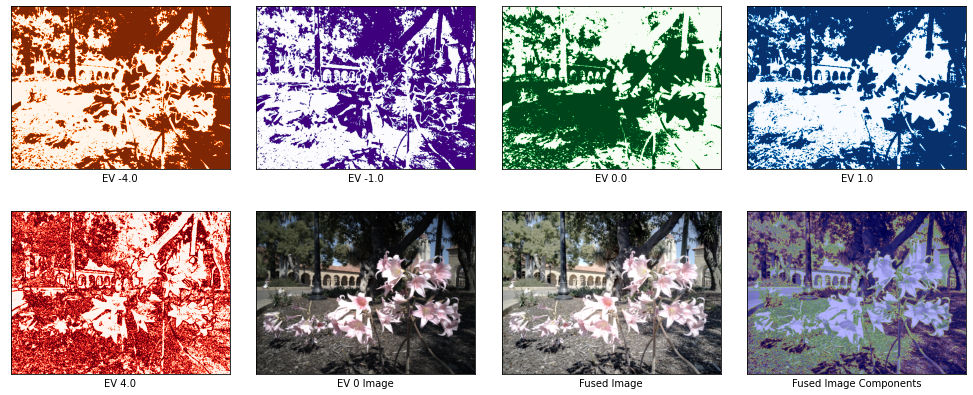

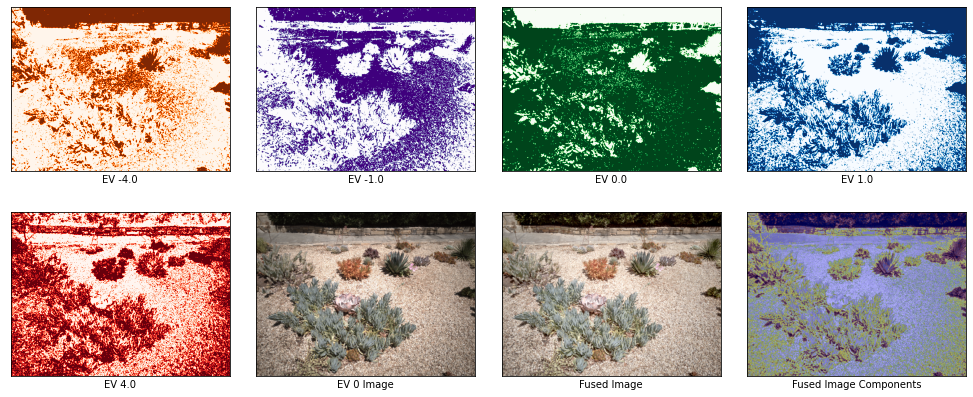

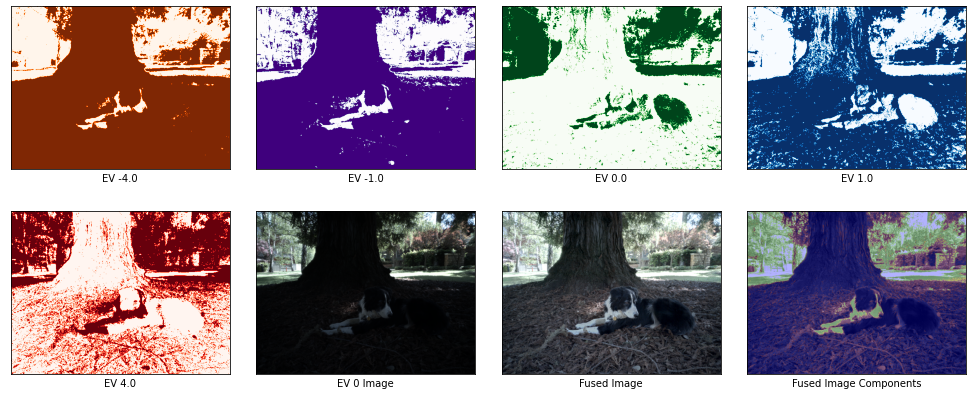

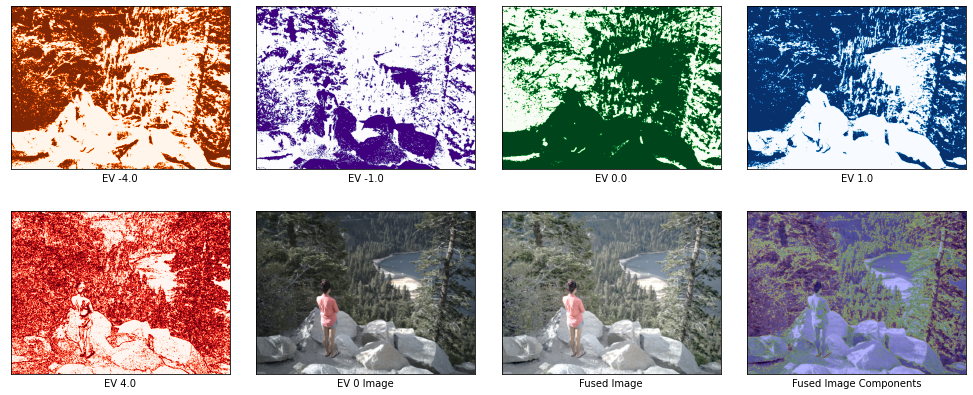

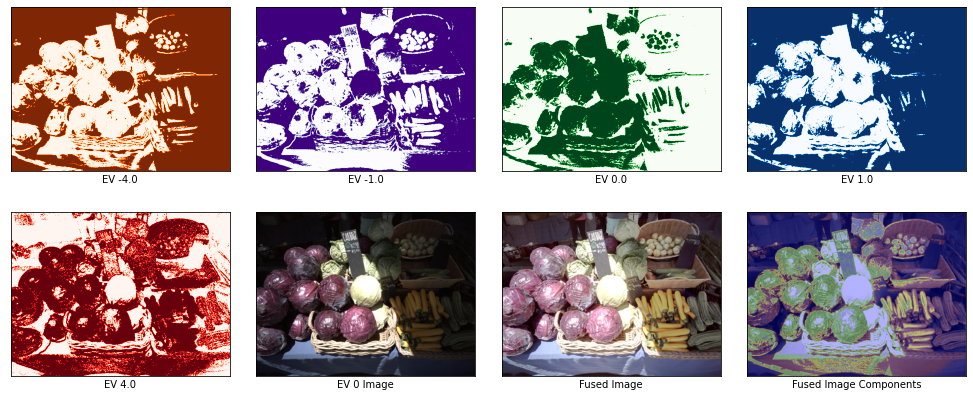

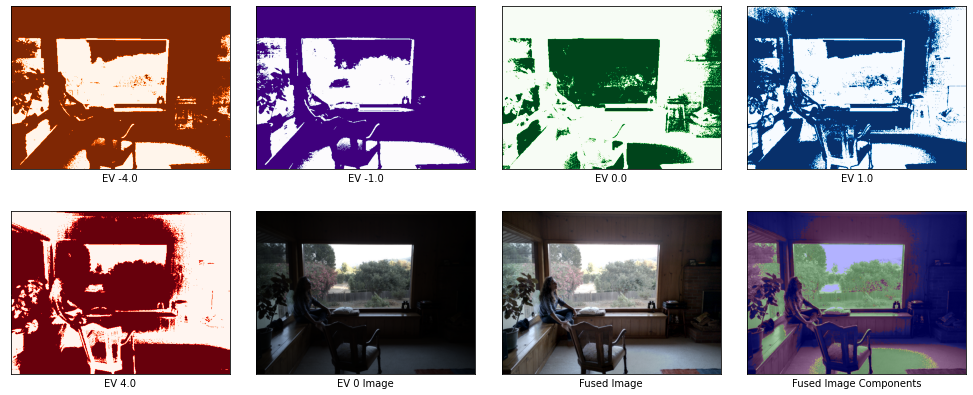

In [9]:
import copy

from more_itertools import one

from dhdrnet.vis_util import binarize_weights, recolour_image

binarized_wms = [[binarize_weights(wm) for wm in wms] for wms in weight_maps_per_image]
print(binarized_wms[0][0].max())
cmaps = ["Oranges", "Purples", "Greens", "Blues", "Reds"]
for weight_maps, fused, name in zip(binarized_wms, fused_images, image_names):
    fig, axs = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(14, 6))
    #     fig.suptitle(f"Weight Maps and Fused Image: {name}")
    fig.tight_layout()
    for ev, wm, ax, cmap in zip(ev_list, weight_maps, np.ravel(axs), cmaps):
        ax.imshow(
            1 - wm,
            interpolation=None,
            cmap=cmap,
        )
        ax.set_xlabel(f"EV {ev}")
        ax.set_xticks([])
        ax.set_yticks([])

    colour_labels, recoloured = recolour_image(
        fused[:, :, [2, 1, 0]], weight_maps, cmaps
    )

    axs[1, 1].imshow(one(generator.get_exposures(name, [0.0]))[..., [2, 1, 0]])
    axs[1, 1].set_xlabel("EV 0 Image")
    axs[1, 1].set_xticks([])
    axs[1, 1].set_yticks([])

    axs[1, 2].imshow(fused[..., [2, 1, 0]])
    axs[1, 2].set_xlabel("Fused Image")
    axs[1, 2].set_xticks([])
    axs[1, 2].set_yticks([])

    axs[1, 3].imshow(recoloured)
    axs[1, 3].set_xlabel("Fused Image Components")
    axs[1, 3].set_xticks([])
    axs[1, 3].set_yticks([])

#     fig.savefig(figdir / f"wm_fused_colours_{name}.pdf")

1


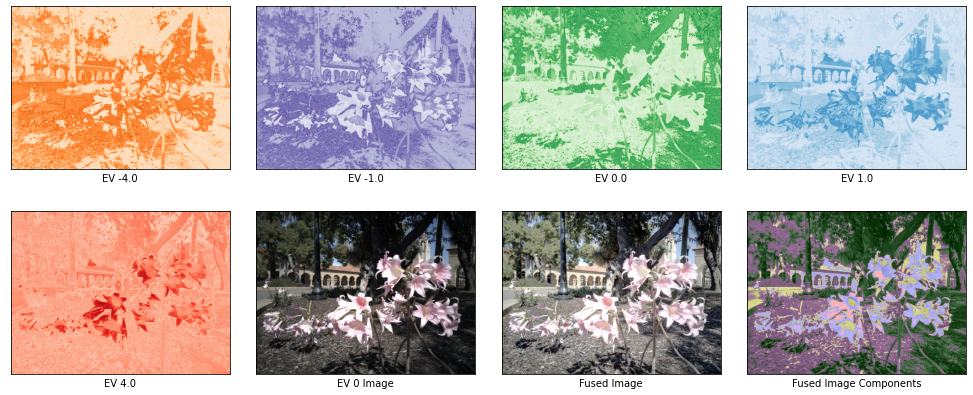

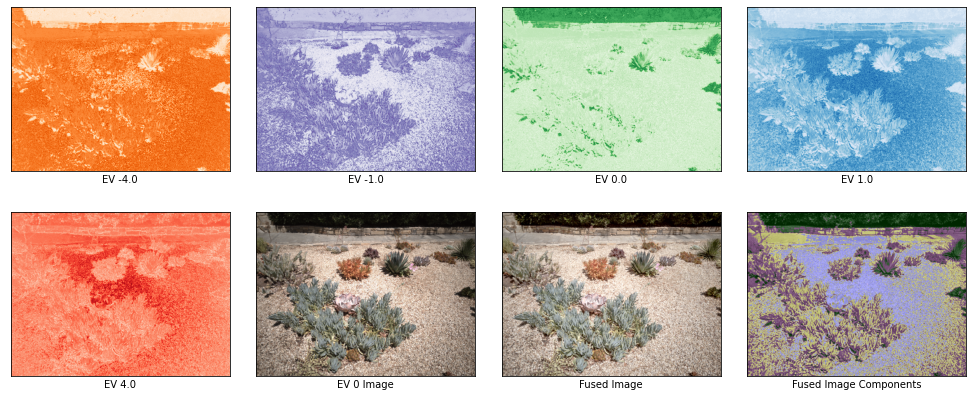

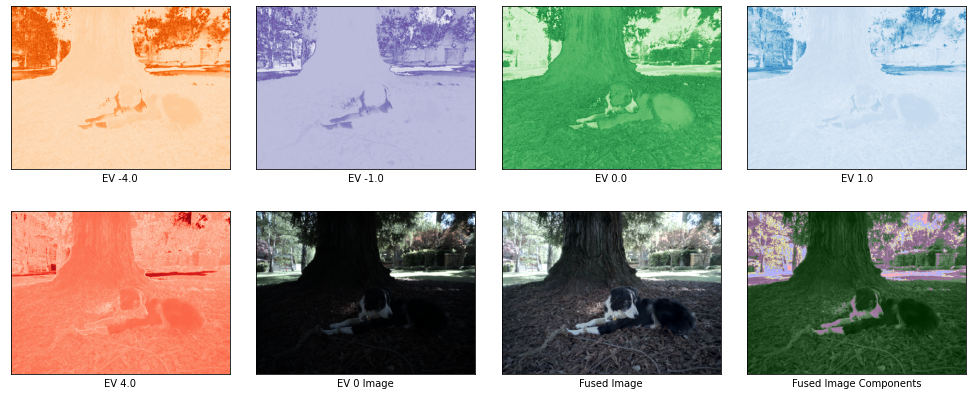

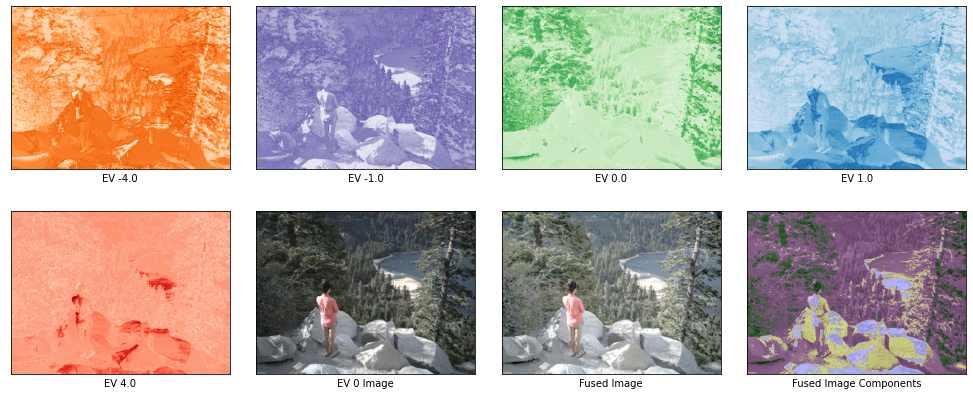

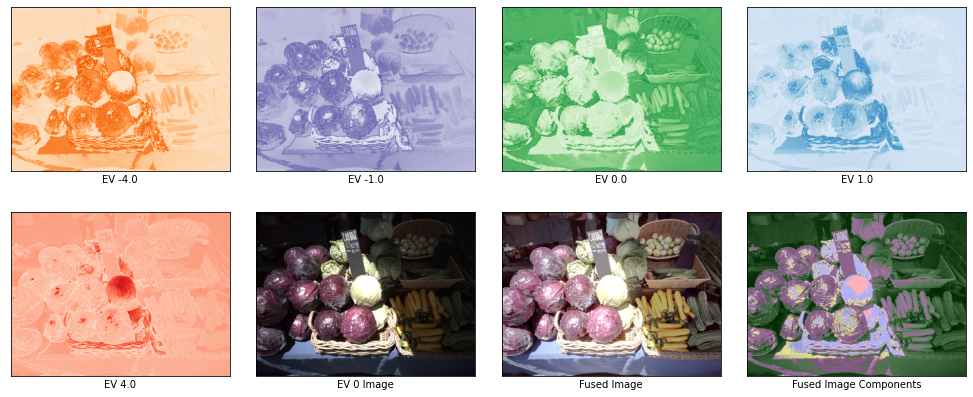

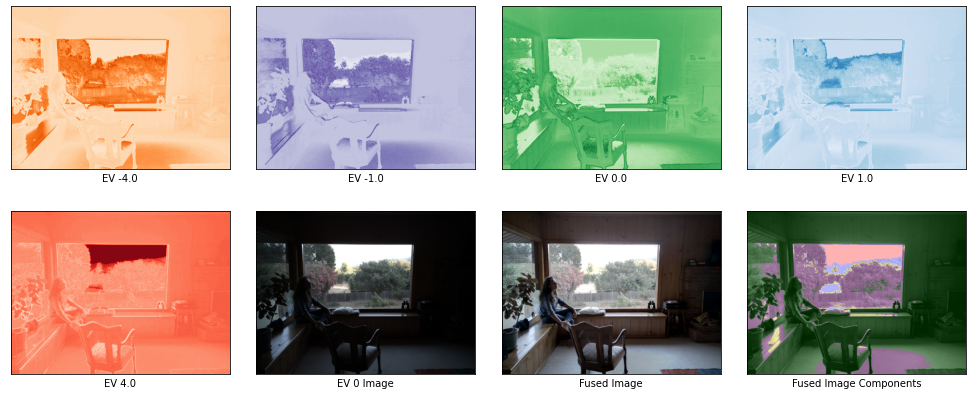

In [7]:
import copy

from more_itertools import one

from dhdrnet.vis_util import binarize_weights, recolour_image

binarized_wms = [[binarize_weights(wm) for wm in wms] for wms in weight_maps_per_image]
print(binarized_wms[0][0].max())
cmaps = ["Oranges", "Purples", "Greens", "Blues", "Reds"]
for weight_maps, fused, name in zip(weight_maps_per_image, fused_images, image_names):
    fig, axs = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(14, 6))
    #     fig.suptitle(f"Weight Maps and Fused Image: {name}")
    fig.tight_layout()
    for ev, wm, ax, cmap in zip(ev_list, weight_maps, np.ravel(axs), cmaps):
        ax.imshow(
            wm,
            interpolation=None,
            cmap=cmap,
        )
        ax.set_xlabel(f"EV {ev}")
        ax.set_xticks([])
        ax.set_yticks([])

    colour_labels, recoloured = recolour_image(
        fused[:, :, [2, 1, 0]], weight_maps, cmaps
    )

    axs[1, 1].imshow(one(generator.get_exposures(name, [0.0]))[..., [2, 1, 0]])
    axs[1, 1].set_xlabel("EV 0 Image")
    axs[1, 1].set_xticks([])
    axs[1, 1].set_yticks([])

    axs[1, 2].imshow(fused[..., [2, 1, 0]])
    axs[1, 2].set_xlabel("Fused Image")
    axs[1, 2].set_xticks([])
    axs[1, 2].set_yticks([])

    axs[1, 3].imshow(recoloured)
    axs[1, 3].set_xlabel("Fused Image Components")
    axs[1, 3].set_xticks([])
    axs[1, 3].set_yticks([])

#     fig.savefig(figdir / f"wm_fused_colours_{name}.pdf")